## Imports

In [733]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, load_digits
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from enum import Enum

## Definindo DataSet

In [734]:
X, y = make_moons(n_samples=500)
np.random.seed(42)

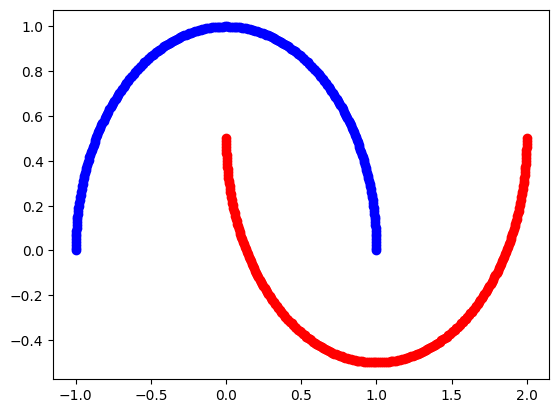

In [735]:
plt.scatter(X[:,0][y==0], X[:,1][y==0], color='blue')
plt.scatter(X[:,0][y==1], X[:,1][y==1], color='red')

# Multilayer perceptron

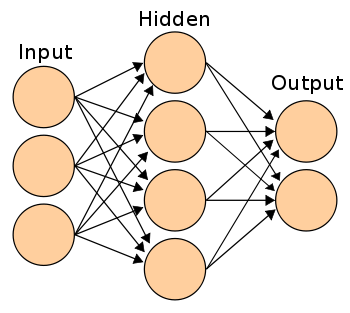

In [736]:
class ActivationFunction(Enum):
    TANH = 'tanh'
    SIGMOID = 'sigmoid'
    SOFTMAX = 'softmax'

class MLP():
    def __init__(self, hidden_neurons:int, output_neurons:int, learning_rate:float, max_iter:int, activation_hidden:ActivationFunction, activation_output:ActivationFunction=ActivationFunction.SOFTMAX) -> None:
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.learning_rate = learning_rate
        self.max_iter = max_iter # epochs
        self.activation_hidden = activation_hidden
        self.activation_output = activation_output

    def predict(self, X) -> np.ndarray:
        """Faz a previsão de valores para os dados de teste."""
        return self.__feedfoward(X)

    def fit(self, X:np.ndarray, y:np.ndarray, show_accuracy=False) -> None:
        self.__init_params(X, y)
        """Realiza o treinamento da rede."""
        for e in range(self.max_iter):
            output = self.__feedfoward(self.__X)
            loss = self.__loss_function(output)

            # Condição de parada
            accuracy = self.__calc_accuracy(output)
            if accuracy == 1:
                print(f'100% de acurácia após {e} épocas. Treinamento concluído.')
                break
            elif show_accuracy:
                print(f'Época: {e} \t Acertos: {accuracy:.3f} \t Perda: {loss:.3f}')

            self.__backpropagation(output)

    def __init_params(self, X:np.ndarray, y:np.ndarray) -> None:
        self.__X = X
        self.__y = y
        self.__input_neurons = self.__X.shape[1]

        # camada inicial para camada oculta
        self.__f1 = None # função de ativação
        self.__w1 = np.random.randn(self.__input_neurons, self.hidden_neurons) # matriz de pesos
        self.__b1 = np.zeros((1, self.hidden_neurons)) # bias

        # camada oculta para saida
        self.__w2 = np.random.randn(self.hidden_neurons, self.output_neurons)
        self.__b2 = np.zeros((1, self.output_neurons))

    def __feedfoward(self, X:np.ndarray) -> np.ndarray:
        """Realiza a propagação direta pela rede neural."""
        z1 = (X @ self.__w1) + self.__b1 # broadcasting
        self.__f1 = self.__activation_function(z1, layer='hidden')
        
        z2 = (self.__f1 @ self.__w2) + self.__b2
        f2 = self.__activation_function(z2, layer='output')

        return f2

    def __activation_function(self,input:np.ndarray, layer:str) -> np.ndarray:
        """Aplica a função de ativação à saída da camada especificada."""
        if layer == 'hidden':
            if self.activation_hidden == ActivationFunction.TANH:
                return np.tanh(input)
            elif self.activation_hidden == ActivationFunction.SIGMOID:
                return 1 / (1 + np.exp(-input))
            else:
                raise ValueError("Função de ativação inválida para a camada oculta.")
        elif layer == 'output':
            if self.activation_output == ActivationFunction.SOFTMAX:
                exp_values = np.exp(input)
                return exp_values / np.sum(exp_values, axis=1, keepdims=True)
            elif self.activation_output == ActivationFunction.SIGMOID:
                return 1 / (1 + np.exp(-input))
            else:
                raise ValueError("Função de ativação inválida para a camada de saída.")
        else:
            raise ValueError("O argumento 'layer' deve ser 'hidden' ou 'output'.")
    
    def __loss_function(self, predictions: np.ndarray) -> float:
        """Calcula a perda da rede neural usando a Cross-Entropy Categórica."""
        # Probabilidades preditas para as classes verdadeiras
        predicted_probabilities = predictions[np.arange(len(predictions)), self.__y]
        loss = -np.log(predicted_probabilities).mean()
        return loss

    def __backpropagation(self, predictions:np.ndarray) -> None:
        """Executa o algoritmo de backpropagation para atualizar os pesos."""
        # Calcula o gradiente da perda em relação à saída
        grad_loss_output = np.copy(predictions)
        true_labels = np.eye(grad_loss_output.shape[1])[self.__y]  # one-hot encoding dos rótulos verdadeiros
        grad_loss_output -= true_labels
        
        # Gradientes da camada de saída
        grad_w2 = self.__f1.T @ grad_loss_output
        grad_b2 = np.sum(grad_loss_output, axis=0, keepdims=True)

        # Calcula o gradiente da perda em relação à entrada da camada oculta
        grad_loss_hidden = (grad_loss_output @ self.__w2.T) * (1 - np.power(self.__f1, 2))
        
        # Gradientes da camada oculta
        grad_w1 = self.__X.T @ grad_loss_hidden
        grad_b1 = np.sum(grad_loss_hidden, axis=0, keepdims=True)

        # Atualiza os pesos e bias das respectivas camadas
        self.__w2 += - self.learning_rate * grad_w2
        self.__b2 += - self.learning_rate * grad_b2
        self.__w1 += - self.learning_rate * grad_w1
        self.__b1 += - self.learning_rate * grad_b1

    def __calc_accuracy(self, predictions:np.ndarray) -> float:
        """Calcula a porcentagem de acertos do modelo."""
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = (predicted_labels == self.__y).sum()
        accuracy = true_labels / self.__X.shape[0]
        return accuracy

### Parâmetros de entrada

In [737]:
hidden_neurons = 10
output_neurons = 2
learning_rate = 0.001
max_iter = 100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Testes

In [738]:
model = MLP(hidden_neurons, output_neurons, learning_rate, max_iter, activation_hidden=ActivationFunction.SIGMOID)
model.fit(X_train, y_train, show_accuracy=True)
ypred = model.predict(X_test)

predicted_labels = np.argmax(ypred, axis=1)
score = accuracy_score(y_test, predicted_labels)
score

Época: 0 	 Acertos: 0.790 	 Perda: 0.581
Época: 1 	 Acertos: 0.840 	 Perda: 0.366
Época: 2 	 Acertos: 0.850 	 Perda: 0.313
Época: 3 	 Acertos: 0.858 	 Perda: 0.304
Época: 4 	 Acertos: 0.863 	 Perda: 0.297
Época: 5 	 Acertos: 0.868 	 Perda: 0.291
Época: 6 	 Acertos: 0.868 	 Perda: 0.285
Época: 7 	 Acertos: 0.868 	 Perda: 0.281
Época: 8 	 Acertos: 0.870 	 Perda: 0.277
Época: 9 	 Acertos: 0.875 	 Perda: 0.274
Época: 10 	 Acertos: 0.875 	 Perda: 0.270
Época: 11 	 Acertos: 0.875 	 Perda: 0.267
Época: 12 	 Acertos: 0.880 	 Perda: 0.265
Época: 13 	 Acertos: 0.880 	 Perda: 0.262
Época: 14 	 Acertos: 0.882 	 Perda: 0.260
Época: 15 	 Acertos: 0.885 	 Perda: 0.257
Época: 16 	 Acertos: 0.885 	 Perda: 0.255
Época: 17 	 Acertos: 0.885 	 Perda: 0.253
Época: 18 	 Acertos: 0.887 	 Perda: 0.251
Época: 19 	 Acertos: 0.890 	 Perda: 0.248
Época: 20 	 Acertos: 0.890 	 Perda: 0.246
Época: 21 	 Acertos: 0.892 	 Perda: 0.244
Época: 22 	 Acertos: 0.892 	 Perda: 0.242
Época: 23 	 Acertos: 0.892 	 Perda: 0.240
Ép

0.97

## Comparativo com Scikit-learn

In [739]:
model = MLPClassifier(hidden_layer_sizes=(hidden_neurons,), activation='tanh', solver='sgd', learning_rate_init=learning_rate, max_iter=max_iter)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

accuracy = accuracy_score(y_test, ypred)
accuracy

/home/lucas/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.92

### Testando outro DataSet

In [740]:
data = load_digits()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hidden_neurons = 30
output_neurons = 10
learning_rate = 0.002
max_iter = 200

In [741]:
model = MLP(hidden_neurons, output_neurons, learning_rate, max_iter, activation_hidden=ActivationFunction.TANH)
model.fit(X_train, y_train, show_accuracy=True)
ypred = model.predict(X_test)

predicted_labels = np.argmax(ypred, axis=1)
score = accuracy_score(y_test, predicted_labels)
score

Época: 0 	 Acertos: 0.022 	 Perda: 9.556
Época: 1 	 Acertos: 0.150 	 Perda: 7.221
Época: 2 	 Acertos: 0.124 	 Perda: 9.347
Época: 3 	 Acertos: 0.153 	 Perda: 11.891
Época: 4 	 Acertos: 0.118 	 Perda: 12.224
Época: 5 	 Acertos: 0.288 	 Perda: 11.966
Época: 6 	 Acertos: 0.204 	 Perda: 12.570
Época: 7 	 Acertos: 0.229 	 Perda: 7.666
Época: 8 	 Acertos: 0.241 	 Perda: 10.836
Época: 9 	 Acertos: 0.243 	 Perda: 12.114
Época: 10 	 Acertos: 0.210 	 Perda: 10.124
Época: 11 	 Acertos: 0.239 	 Perda: 9.407
Época: 12 	 Acertos: 0.262 	 Perda: 10.107
Época: 13 	 Acertos: 0.166 	 Perda: 11.401
Época: 14 	 Acertos: 0.314 	 Perda: 11.836
Época: 15 	 Acertos: 0.236 	 Perda: 7.777
Época: 16 	 Acertos: 0.402 	 Perda: 7.750
Época: 17 	 Acertos: 0.262 	 Perda: 9.946
Época: 18 	 Acertos: 0.309 	 Perda: 7.156
Época: 19 	 Acertos: 0.260 	 Perda: 9.693
Época: 20 	 Acertos: 0.279 	 Perda: 9.360
Época: 21 	 Acertos: 0.286 	 Perda: 7.636
Época: 22 	 Acertos: 0.315 	 Perda: 7.483
Época: 23 	 Acertos: 0.444 	 Perda

0.9166666666666666

In [742]:
model = MLPClassifier(hidden_layer_sizes=(hidden_neurons,), activation='tanh', solver='sgd', learning_rate_init=learning_rate, max_iter=max_iter)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

accuracy = accuracy_score(y_test, ypred)
accuracy

/home/lucas/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9555555555555556